# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.329791
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *W is very small which will result in scores being very low*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.845483 analytic: 1.845483, relative error: 5.658631e-08
numerical: 3.009640 analytic: 3.009640, relative error: 6.668760e-09
numerical: -0.197992 analytic: -0.197992, relative error: 1.923959e-07
numerical: -1.320763 analytic: -1.320763, relative error: 2.325649e-08
numerical: 0.977171 analytic: 0.977171, relative error: 7.410594e-08
numerical: -0.640170 analytic: -0.640170, relative error: 6.013610e-08
numerical: 0.322750 analytic: 0.322750, relative error: 3.372990e-08
numerical: -0.029011 analytic: -0.029011, relative error: 5.533710e-07
numerical: 3.236951 analytic: 3.236951, relative error: 6.477095e-09
numerical: -1.327471 analytic: -1.327471, relative error: 8.216060e-09
numerical: -1.872069 analytic: -1.872069, relative error: 7.848994e-09
numerical: 1.023911 analytic: 1.023911, relative error: 6.147792e-08
numerical: -3.727116 analytic: -3.727116, relative error: 7.194527e-09
numerical: -3.500109 analytic: -3.500109, relative error: 7.699278e-10
numerical: -2.4272

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.329791e+00 computed in 4.082808s
vectorized loss: 2.329791e+00 computed in 0.005195s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 1e-6, 1e-5]
regularization_strengths = [1, 100, 1000, 100000.0/2, 100000]#, 300000, 400000, 1000000] #, 1000, 5e4, 1e5, 5e5, 1e6]#, 5e7, 1e8]
#regularization_strengths = [100000, 200000, 300000, 400000, 1000000]#, 5e7, 1e8]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, batch_size=250,
                          num_iters=3000, verbose=False)
        y_train_pred = softmax.predict(X_train)
        #print softmax.W[0,:10]
        y_val_pred = softmax.predict(X_val)
        #print (y_val == y_val_pred).shape, (y_train == y_train_pred).shape
        print lr, reg,  np.mean(y_train == y_train_pred), (np.mean(y_val == y_val_pred))
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred))
        #print y_val_pred[:10], y_val[:10], (y_val_pred == y_val)[:10]
        #print np.sum(y_val_pred == y_val), np.sum(y_train == y_train_pred)
        if val_accuracy > best_val:
            best_softmax = softmax
            best_val = val_accuracy
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val


1e-07 1 0.27593877551 0.268
1e-07 100 0.281081632653 0.271
1e-07 1000 0.297959183673 0.302
1e-07 50000.0 0.323734693878 0.346
1e-07 100000 0.302897959184 0.321
1e-06 1 0.379081632653 0.362
1e-06 100 0.393714285714 0.393
1e-06 1000 0.416224489796 0.409
1e-06 50000.0 0.316714285714 0.33
1e-06 100000 0.288571428571 0.305
1e-05 1 0.345836734694 0.322
1e-05 100 0.302795918367 0.311
1e-05 1000 0.288775510204 0.289
1e-05 50000.0 0.169857142857 0.148
1e-05 100000 0.145326530612 0.148
1

cs231n/classifiers/softmax.py:93: RuntimeWarning: divide by zero encountered in log
  loss = -1 *  np.sum(np.log(np.sum(probablities * y_onehot, axis=1))) / X.shape[0]
cs231n/classifiers/softmax.py:94: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W*W)


 1 0.128428571429 0.151
1 100 0.100265306122 0.087
1

cs231n/classifiers/softmax.py:82: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1).reshape(scores.shape[0],1)
cs231n/classifiers/softmax.py:82: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1).reshape(scores.shape[0],1)
cs231n/classifiers/softmax.py:97: RuntimeWarning: overflow encountered in multiply
  dW = X.T.dot(del_L) / X.shape[0] + reg * W


 1000 0.100265306122 0.087
1 50000.0 0.100265306122 0.087
1 100000 0.100265306122 0.087
lr 1.000000e-07 reg 1.000000e+00 train accuracy: 0.275939 val accuracy: 0.268000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.281082 val accuracy: 0.271000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.297959 val accuracy: 0.302000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.323735 val accuracy: 0.346000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.302898 val accuracy: 0.321000
lr 1.000000e-06 reg 1.000000e+00 train accuracy: 0.379082 val accuracy: 0.362000
lr 1.000000e-06 reg 1.000000e+02 train accuracy: 0.393714 val accuracy: 0.393000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.416224 val accuracy: 0.409000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.316714 val accuracy: 0.330000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.288571 val accuracy: 0.305000
lr 1.000000e-05 reg 1.000000e+00 train accuracy: 0.345837 val accuracy: 0.322000
lr 1.000000e-05 reg 1

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
print np.sum(y_test == y_test_pred)
print (y_test == y_test_pred).shape
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

399
(1000,)
softmax on raw pixels final test set accuracy: 0.399000


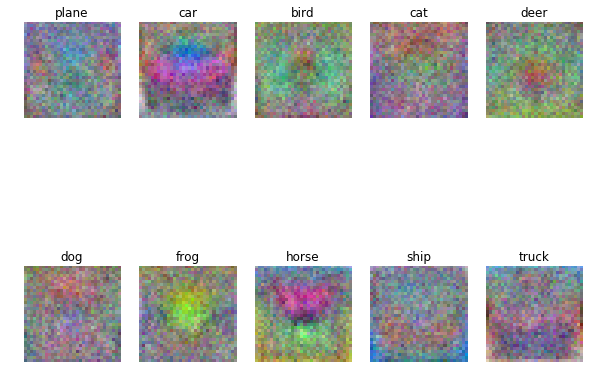

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])